## Compare equatorial ocean metrics between obs and MOM6 run
1) Thermocline depth, gradient, strength | TO DO : gradient!
2) Compare cold tongue strength
3) EUC MOM6 vs obs, strength, depth | TO DO : think of something to come up with a number to quantify?

Is there anything specific for the Indian ocean I should be looking at?

Obs data: 

- /glade/p/cesm/omwg/obs_data/phc/PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc 
- /glade/p/cesm/omwg/obs_data/phc/PHC2_SALT_tx0.66v1_34lev_ann_avg.nc 
- /glade/p/cesm/omwg/obs_data/johnson_pmel/meanfit_m.nc

In [1]:
# Load required modules
import warnings
warnings.filterwarnings("ignore") # I don't want any warnings (: 

# the usual suspects
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import glob
import nc_time_axis # it says I need this to plot.. not sure 

# dask helpers 
from distributed import Client
from ncar_jobqueue import NCARCluster

# get mom6-tools 
import mom6_tools

In [192]:
cluster = NCARCluster(cores=4,
    processes=1,
    resource_spec='select=1:ncpus=1:mem=10GB',
)
cluster.scale(30)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/high-mem/proxy/35297/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/high-mem/proxy/35297/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.57:42769,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/high-mem/proxy/35297/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
# get the data from the coupled run 
dirname = "/glade/scratch/gmarques/bmom.e23.f09_t061_zstar_N65.nuopc.GM_tuning.002/run"
static = xr.open_dataset(*glob.glob(f"{dirname}/*static*.nc"))
ds_coupled = xr.open_mfdataset(
    sorted(glob.glob(f"{dirname}/*.mom6.h_*.nc")),
    coords="minimal",
    data_vars="minimal",
    compat="override",
    use_cftime=True,
    parallel=True,
)
ds_coupled.coords.update(static.drop("time"))

# time averaging
thetao = ds_coupled.thetao.mean('time')
so = ds_coupled.so.mean('time')
uo = ds_coupled.uo.mean('time')
eta = ds_coupled.e.mean('time')

j = np.abs(ds_coupled.yh).argmin().values

thetao_eq_mom = thetao.isel(yh=slice(j-5,j+5)).mean('yh');
salt_eq_mom = so.isel(yh=slice(j-5,j+5)).mean('yh');

In [103]:
# load obs 
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc')
phc_salt = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc')
johnson = xr.open_dataset('/glade/p/cesm/omwg/obs_data/johnson_pmel/meanfit_m.nc')

# get theta and salt and rename coordinates to be the same as the model's
thetao_obs = phc_temp.TEMP.rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'});
salt_obs = phc_salt.SALT.rename({'X': 'xh','Y': 'yh', 'depth': 'z_l'});

# set coordinates to the same as the model's
thetao_obs['xh'] = ds_coupled.xh; thetao_obs['yh'] = ds_coupled.yh;
salt_obs['xh'] = ds_coupled.xh; salt_obs['yh'] = ds_coupled.yh;

# get the equatorial zone +-5 degrees  
thetao_eq_obs = thetao_obs.isel(yh=slice(j-5,j+5)).mean('yh');
salt_eq_obs = salt_obs.isel(yh=slice(j-5,j+5)).mean('yh')

In [20]:
y = ds_coupled.yh.values
zz = ds_coupled.z_i.values
x = ds_coupled.xh.values
[X, Z] = np.meshgrid(x, zz)
z = 0.5 * ( Z[:-1] + Z[1:])

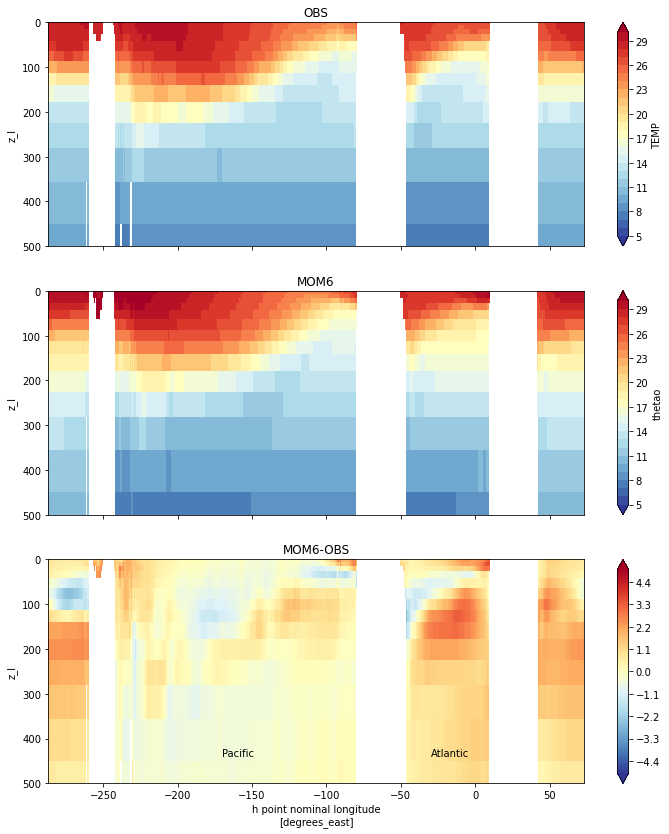

In [106]:
fig, ax = plt.subplots(3, 1, figsize=(12, 14), sharex=True, sharey=True)
thetao_eq_obs.plot(y='z_l', ylim=(500,0), levels=np.arange(5,31,1), cmap='RdYlBu_r', extend='both', ax=ax[0])
ax[0].set_title('OBS')
ax[0].set_xlabel('')

thetao_eq_mom.plot(y='z_l', ylim=(500,0), levels=np.arange(5,31,1), cmap='RdYlBu_r',  extend='both', ax=ax[1])
ax[1].set_title('MOM6')
ax[1].set_xlabel('')

(thetao_eq_mom-thetao_eq_obs).plot(y='z_l', ylim=(500,0), levels=np.arange(-5,5.1,.1), cmap='RdYlBu_r', extend='both', ax=ax[2])
ax[2].set_title('MOM6-OBS')

ax[2].text(-170, 440, 'Pacific')
ax[2].text(-30, 440, 'Atlantic')
plt.savefig('Eq_temp_MOM6_obs.png', bbox_inches='tight')

In [116]:
tc_eq_mom = thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')
tc_eq_obs = thetao_eq_obs.differentiate('z_l').fillna(0).argmin(dim='z_l')

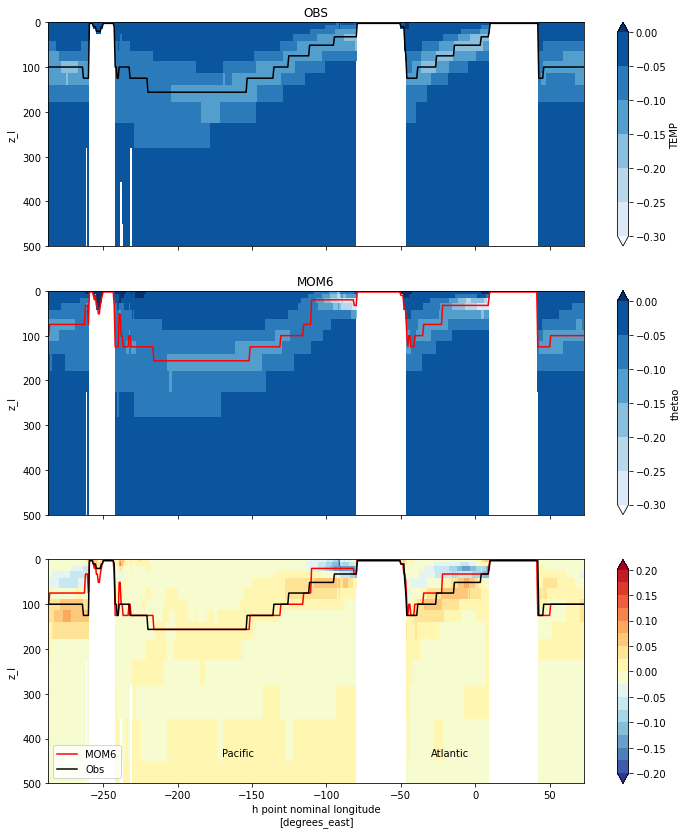

In [107]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True, sharey=True)
thetao_eq_obs.differentiate('z_l').plot(y='z_l', ylim=(300,0), levels=np.arange(0,-0.35,-0.05), 
                                                                        cmap='Blues', extend='both', ax=ax[0])
thetao_eq_obs['z_l'][thetao_eq_obs.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='Obs', ax=ax[0], c='k')
ax[0].set_title('OBS')
ax[0].set_xlabel('')

thetao_eq_mom.differentiate('z_l').plot(y='z_l', ylim=(300,0), levels=np.arange(0,-0.35,-0.05),
                                                                    cmap='Blues', extend='both', ax=ax[1])
thetao_eq_mom['z_l'][thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='MOM6', ax=ax[1], c='red')
ax[1].set_title('MOM6')
ax[1].set_xlabel('')

(thetao_eq_mom-thetao_eq_obs).differentiate('z_l').plot(y='z_l', ylim=(300,0), levels=np.arange(-0.2,0.225,0.025), 
                                                                                 cmap='RdYlBu_r', extend='both', ax=ax[2])
ax[2].set_title('MOM6-OBS')
thetao_eq_mom['z_l'][thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='MOM6', ax=ax[2], c='red')
thetao_eq_obs['z_l'][thetao_eq_obs.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='Obs', ax=ax[2], c='k')
ax[2].legend()

ax[2].text(-170, 440, 'Pacific')
ax[2].text(-30, 440, 'Atlantic')
plt.savefig('Eq_diff_temp_MOM6_obs.png', bbox_inches='tight')

CPU times: user 11.8 s, sys: 480 ms, total: 12.3 s
Wall time: 27.1 s


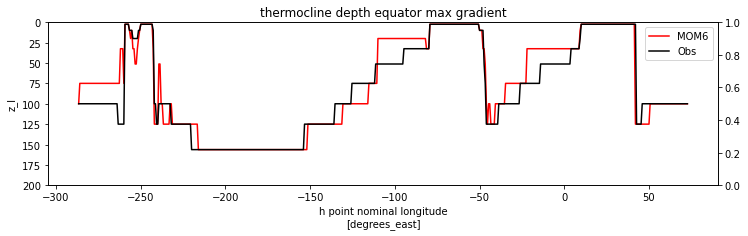

In [115]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex=True, sharey=True)

thetao_eq_mom['z_l'][tc_eq_mom].plot(label='MOM6', ax=ax, c='red')
thetao_eq_obs['z_l'][tc_eq_obs].plot(label='Obs', ax=ax, c='k', ylim=(200,0))
ax.legend()
ax.set_title('thermocline depth equator max gradient')

plt.savefig('thermocline_depth_mom6_obs_bias.png', bbox_inches='tight')

### Do the zonal thermocline gradient next!

# EUC
- depth
- strength
- gradient

In [118]:
u_eq_mom = uo.isel(yh=slice(j-5,j+5)).mean('yh');

In [178]:
johnson['XLON'] = (johnson.XLON-360)

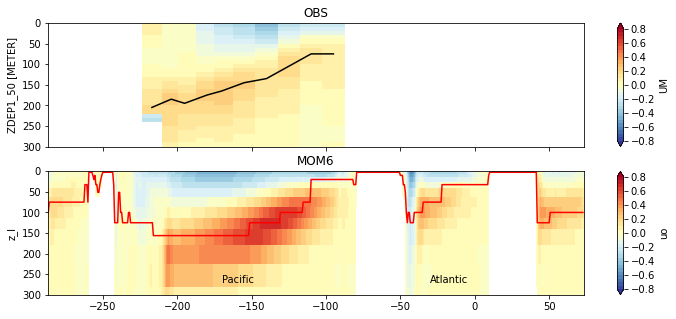

In [183]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)
(johnson.UM).sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').plot(y='ZDEP1_50', ylim=(300,0), levels=np.arange(-0.8,0.85,0.05), 
                                                                        cmap='RdYlBu_r', extend='both', ax=ax[0])
johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')].plot(label='Obs', ax=ax[0], c='k')
ax[0].set_title('OBS')
ax[0].set_xlabel('')

(u_eq_mom).plot(y='z_l', ylim=(300,0), levels=np.arange(-0.8,0.85,0.05), cmap='RdYlBu_r', extend='both', ax=ax[1])
u_eq_mom['z_l'][thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='MOM6', ax=ax[1], c='red')
ax[1].set_title('MOM6')
ax[1].set_xlabel('')

ax[1].text(-170, 270, 'Pacific')
ax[1].text(-30, 270, 'Atlantic')

plt.savefig('Eq_U_MOM6_obs.png', bbox_inches='tight')

CPU times: user 12.4 s, sys: 563 ms, total: 12.9 s
Wall time: 27.7 s


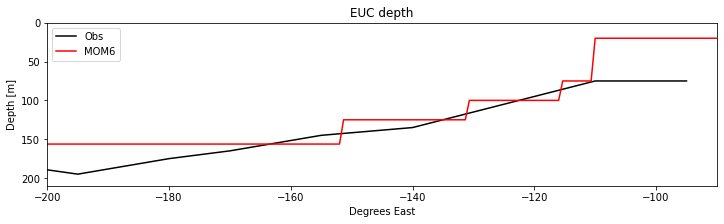

In [185]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex=True, sharey=True)

johnson['ZDEP1_50'][johnson.UM.sel(YLAT11_101=slice(-5,5)).mean('YLAT11_101').argmax(dim='ZDEP1_50')].plot(label='Obs', ax=ax, c='k')
u_eq_mom['z_l'][thetao_eq_mom.differentiate('z_l').fillna(0).argmin(dim='z_l')].plot(label='MOM6', ax=ax, c='red')
ax.legend()
ax.set_xlim(-200,-90)
ax.set_title('EUC depth')
ax.set_ylim(210,0)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Degrees East')
plt.savefig('EUC_johnson_mom6.png', bbox_inches='tight')

#### it looks like the metrics are different but the values actually line up??

In [170]:
johnson.UM.attrs

{'long_name': 'U component of velocity',
 'history': 'From meanfit2',
 'units': 'cm/s'}

In [172]:
ds_coupled.uo.attrs

{'units': 'm s-1',
 'long_name': 'Sea Water X Velocity',
 'cell_methods': 'z_l:mean yh:mean xq:point time: mean',
 'time_avg_info': 'average_T1,average_T2,average_DT',
 'standard_name': 'sea_water_x_velocity',
 'interp_method': 'none'}

# Cold tongue
Think of some metrics rather than just the plot

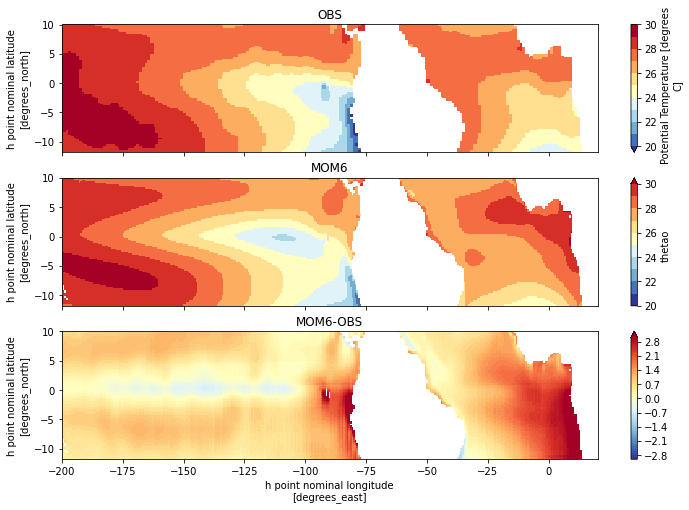

In [205]:
fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True, sharey=True)

thetao_obs.isel(z_l=0).sel(yh=slice(-12, 10)).plot(ax=ax[0], levels=np.arange(20,31,1), cmap='RdYlBu_r', xlim=(-200,20));
ax[0].set_xlabel('');
ax[0].set_title('OBS');

thetao.isel(z_l=0).sel(yh=slice(-12, 10)).plot(ax=ax[1], levels=np.arange(20,31,1), cmap='RdYlBu_r', xlim=(-200,20));
ax[1].set_title('MOM6');
ax[1].set_xlabel('');

(thetao-thetao_obs).isel(z_l=0).sel(yh=slice(-12, 10)).plot(ax=ax[2], levels=np.arange(-3,3.1,0.1), cmap='RdYlBu_r', xlim=(-200,20));
ax[2].set_title('MOM6-OBS');

plt.savefig('cold_tongues_obs_mom6.png', bbox_inches='tight');